# Stop and Frisk data exploration
<br>
In this notebook, I look at the NYPD stop and frisk data. I'm trying to uncover patterns in police interactions, looking at things like race bias, geographic distribution, sexism, ageism etc... What variables drive the type of interaction we have with the police in NYC? 

<br>
If you want to run this notebook yourself, download the data and run the appendix first to get the list of features for each model.
<br>
Sections: <br>
<a href='#dt_imp'> Data Import </a> - get data, look at distributions by race 
<br>
<a href='#frisk_model'> Frisk Model </a> - can I predict if a suspect was frisked only based on immediately observed features
<br>
<a href='#arrest_made'> Arrest Model </a> - can I predict if a suspect was arrested using all info available at that time?
<br>
<a href='#appendix'> Appendix </a> - all my feature selection for each model. These are long lists, and not so fun.

<br> <br>
On the data: <br>
This data is not perfect. It is self reported, and comes from the police itself. Some of the variables may be misreported to retro-fit a desired explanation for an incident. Ex: in the "reason for frisk" features, policemen may say they saw furtive movements, when in fact it was a gut feeling/another reason that is frowned upon. Since we are looking for policing bias, it is likely this socially undesired bias is underreported in this dataset.

<a id='dt_imp'></a>

<h3> Data import, basic pre-processing and distributions by race

In [1]:
import pandas as pd
import numpy as np

In [612]:
df=pd.read_csv('sqf-2016.csv')

C:\Users\Baptiste\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from Pandas_initial_profiler.profiler import dtype_profiler

In [4]:
dtype_profiler.dtype_profiler(df, check_nan=True, hist=3, top_x=3)

COL  1 OF  112 :  year
BASICS: numpy dtype:  object    | dtype:  true string   | flag:  none      | non null:  12405 

UNIQUE:            #_____________________________ .000 3/12405
DTYPES:
  int              IIIIIIIIIIIIIIIIIII...........  
  int-like string                     iiiiiiiiii.  
  string                                        S  

VALUE COUNTS :
2016 :                            ###################___________ .660 8192/12405  | 
2016 :                            ###########___________________ .340 4212/12405  | 
  :                               #_____________________________ .000 1/12405  | 

------------------------------------------------------------------------------------------------------------------------
COL  2 OF  112 :  pct
BASICS: numpy dtype:  object    | dtype:  true string   | flag:  none      | non null:  12405 

UNIQUE:            #_____________________________ .012 155/12405
DTYPES:
  int              IIIIIIIIIIIIIIIIIII...........  
  int-like string    

<b> Before we start, let's do a bit of data pre-processing. </b> <br>
All the numerical columns are stored as objects. Let's convert those, and change all nans or equivalent to 0

In [4]:
#some of these aren't technicall numericals, but there's no leading 0s and they're digits
num_i=['year', 'pct', 'compyear', 'comppct', 'repcmd', 'revcmd', 'age'
           ]
num_f=['weight', 'ht_feet']

In [5]:
#No 0s in any of the numerical columns - I can safely impute nans as 0s for now
for col in num_i:
    print(sum(df[col][df[col]==0]))
for col in num_f:
    print(sum(df[col][df[col]==0]))

0
0
0
0
0
0
0
0
0


In [6]:
for col in num_f:
    df.loc[df[col].isin(['', ' ']), col]=0
    df[col]=df[col].astype(float)
for col in num_i:
    try:
        df.loc[df[col].isin(['', ' ', '**']), col]=0
        df[col]=df[col].astype(int)
    except ValueError:
        print(col, df[col].iloc[1:10])

Basic feature engineering: Changing time of stop to hour of stop

In [347]:
#This is a very ugly function which I wrote quickly. Definitely a way to automate this.
def timestop_to_tofday(time):
    time_str=str(time)
    
    if(len(time_str)==4):
        h=int(time_str[0:2])
    elif(len(time_str)==3):
        h=int(time_str[0])
    elif(time_str in ['', ' ']):
        return 'N'
    else:
        h=0
    
    #6 buckets for time, with 5 being the latest and 0 being the lowest
    
    return int(h/6)
        
df['timestop']=df['timestop'].apply(timestop_to_tofday)

In [7]:
dtype_profiler.dtype_profiler(df, top_x=3, hist=3, check_nan=True, vc_nonan=True)

COL  1 OF  112 :  year
BASICS: numpy dtype:  int32     | dtype:  possibly bool-like  | flag:  none      | non null:  12405 

UNIQUE:            #_____________________________ .000 2/12405
VALUE COUNTS :
2016 :                            #############################_ 1    12404/12405  | 0.9999
0 :                               #_____________________________ .000 1/12405  | 0.0001

------------------------------------------------------------------------------------------------------------------------
COL  2 OF  112 :  pct
BASICS: numpy dtype:  int32     | dtype:  int-like      | flag:  none      | non null:  12405 

UNIQUE:            #_____________________________ .006 78/12405
VALUE COUNTS :
106 :                             ####__________________________ .102 1264/12405  | 0.1019
49 :                              ##____________________________ .046 566/12405  | 0.0456
114 :                             #_____________________________ .031 382/12405  | 0.0308

--------------------------

In [348]:
#Dropping noninteresting variables
df.drop(['year', 'ser_num', 'state'], inplace=True, axis=1)

ValueError: labels ['year' 'ser_num' 'state'] not contained in axis

In [349]:
df['arstmade'].value_counts()

N    9761
Y    2643
        1
Name: arstmade, dtype: int64

Problem with height variable

In [381]:
def height_to_float(h):
    if h in ['', ' ']:
        return np.NaN
    else:
        return float(h)
    
df['ht_inch']=df['ht_inch'].apply(height_to_float)

In [382]:
df['ht_inch'].fillna(value=df['ht_inch'].median(), inplace=True)

Histograms: breaking down the value counts for each race

In [10]:
#subset races
df['race'].value_counts()

B    6498
Q    2753
W    1270
P     873
A     737
Z     140
U      95
I      38
        1
Name: race, dtype: int64

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

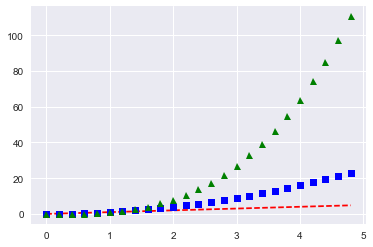

In [13]:
nrow = 1; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=nrow)

for ax in axs.reshape(-1):
  ax.set_ylabel(str(i))

In [103]:
#Function that creates a graph breaking down a variable by race. Pass a LIST in the cols argument
def breakdown_by_race(cols):
    n_plots=len(cols)
    l=len(df)
    
    #set up 3 races datasets
    black=df[df['race']=='B']
    hisp=df[df['race']=='Q']
    white=df[df['race']=='W']    
    
    #set up the subplots
    fig, axs = plt.subplots(n_plots, 1, figsize=(10,5*n_plots))
    fig.tight_layout(h_pad=10.0)

    #main loop graphing
    for ax, i in zip(axs, range(n_plots)):
        column=cols[i]
        
        #x labels
        x=white[column].unique()
        
        #value counts for 3 main races
        y_w=white[column].value_counts(normalize=True).reset_index()
        y_b=black[column].value_counts(normalize=True).reset_index()
        y_q=hisp[column].value_counts(normalize=True).reset_index()
        
        #create x_ticks,sort
        sorter=y_b.iloc[:,0]
        sorterIndex = dict(zip(sorter,range(len(sorter))))
        
        for frame in [y_w, y_b, y_q]:
            frame['rank'] = frame.iloc[:,0].map(sorterIndex)
            frame.sort(['rank'], ascending=True, inplace = True)
            frame.drop(['rank', 'index'], 1, inplace = True)
            
        #plotting
        ax.plot(np.array(y_w), alpha=0.5, color='b', label='white')
        ax.plot(np.array(y_b), alpha=0.5, color='g', label='black')
        ax.plot(np.array(y_q), alpha=0.5, color='r', label='hisp')
        ax.legend(prop={'size':20})
        
        #mapping xtick onto graph
        ax.set_xticks(range(len(y_w)))
        ax.set_xticklabels(sorter, rotation='vertical', fontsize=10)
        ax.set_title(column)

In [85]:
print("[")
for x in sorted(df.columns):
    print("\""+x+"\""+",")
print("]")

[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"addrnum",
"addrpct",
"addrtyp",
"adtlrept",
"age",
"aptnum",
"arstmade",
"arstoffn",
"asltweap",
"beat",
"build",
"city",
"comppct",
"compyear",
"contrabn",
"crimsusp",
"crossst",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"datestop",
"detailCM",
"dettypCM",
"dob",
"explnstp",
"eyecolor",
"forceuse",
"frisked",
"haircolr",
"ht_feet",
"ht_inch",
"inout",
"knifcuti",
"lineCM",
"machgun",
"officrid",
"offshld",
"offunif",
"offverb",
"othfeatr",
"othpers",
"othrweap",
"pct",
"perobs",
"perstop",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"post",
"premname",
"premtype",
"race",
"radio",
"recstat",
"repcmd",
"rescode",
"revcmd",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_

Click on the cells below to see a breakdown of each batch of the variables. To see the variables in each batch, head over to the appendix

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


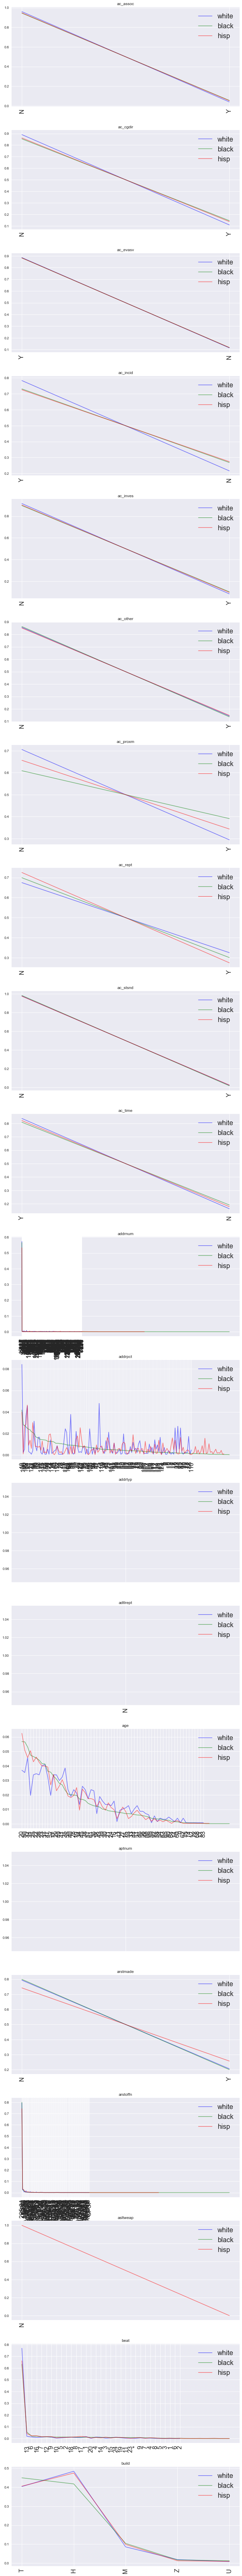

In [91]:
breakdown_by_race(batch_1)

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


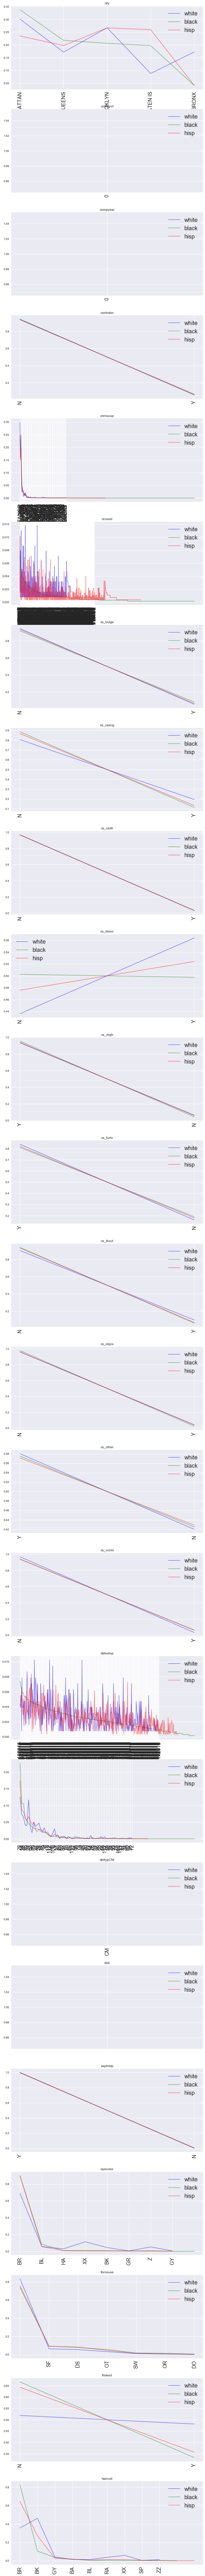

In [92]:
breakdown_by_race(batch_2)

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


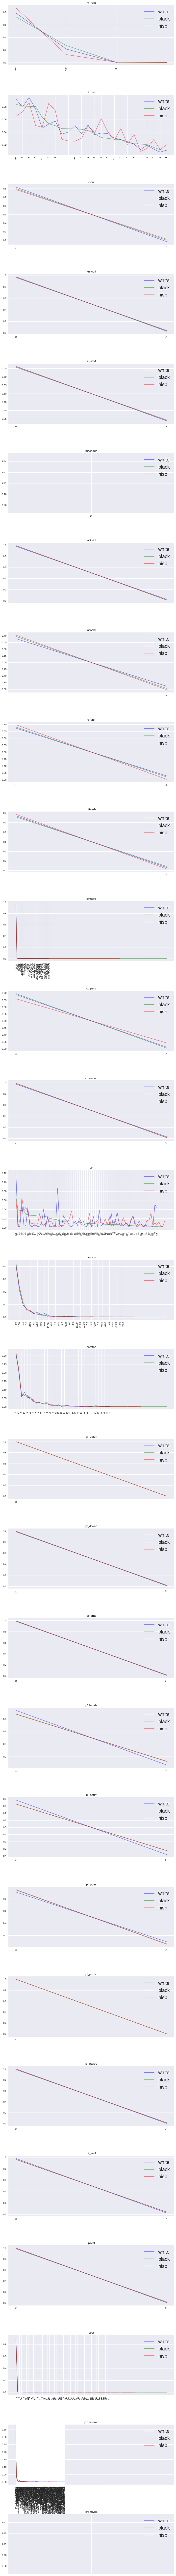

In [105]:
breakdown_by_race(batch_3)

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


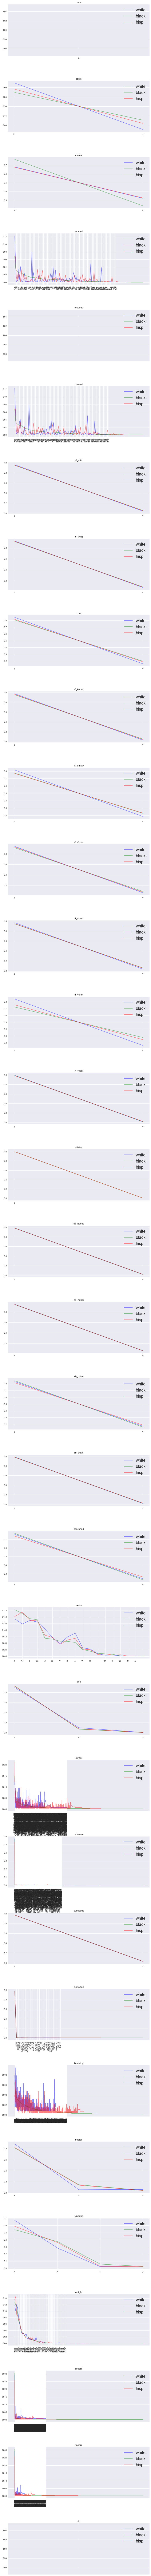

In [106]:
breakdown_by_race(batch_4)

In [112]:
for x in sorted(df.columns):
    print(x)

ac_assoc
ac_cgdir
ac_evasv
ac_incid
ac_inves
ac_other
ac_proxm
ac_rept
ac_stsnd
ac_time
addrnum
addrpct
addrtyp
adtlrept
age
aptnum
arstmade
arstoffn
asltweap
beat
build
city
comppct
compyear
contrabn
crimsusp
crossst
cs_bulge
cs_casng
cs_cloth
cs_descr
cs_drgtr
cs_furtv
cs_lkout
cs_objcs
cs_other
cs_vcrim
datestop
detailCM
dettypCM
dob
explnstp
eyecolor
forceuse
frisked
haircolr
ht_feet
ht_inch
inout
knifcuti
lineCM
machgun
officrid
offshld
offunif
offverb
othfeatr
othpers
othrweap
pct
perobs
perstop
pf_baton
pf_drwep
pf_grnd
pf_hands
pf_hcuff
pf_other
pf_pepsp
pf_ptwep
pf_wall
pistol
post
premname
premtype
race
radio
recstat
repcmd
rescode
revcmd
rf_attir
rf_bulg
rf_furt
rf_knowl
rf_othsw
rf_rfcmp
rf_vcact
rf_vcrim
rf_verbl
riflshot
sb_admis
sb_hdobj
sb_other
sb_outln
searched
sector
sex
stinter
stname
sumissue
sumoffen
timestop
trhsloc
typeofid
weight
xcoord
ycoord
zip


In [175]:
#all the variables that seem to have significant racial differences

racial_dif=['ac_incid', 'ac_proxm', 'ac_rept', 'build', 'city', 'cs_casng', 'cs_descr',
           'cs_furtv', 'cs_lkout', 'cs_other', 'forceuse', 'frisked', 'ht_feet', 'offshld',
           'offunif', 'othpers', 'pf_hands', 'pf_hcuff', 'pf_other', 'radio', 'rf_furt', 'rf_othsw',
           'rf_vcrim', 'typeofid', 'race']

Surprising find: 1/3 suspects are arrested but not searched, but given you are searched you have a 3/5 chance of getting arrested. <br>
As expected, suspects are frisked more than they are searched, and searched more than they are arrested.

In [427]:
srched=df[df['searched']=='Y']
srched['arstmade'].value_counts()

Y    1827
N    1131
Name: arstmade, dtype: int64

In [428]:
df['arstmade'].value_counts()

N    9761
Y    2643
        1
Name: arstmade, dtype: int64

In [429]:
df['frisked'].value_counts()

Y    7939
N    4465
        1
Name: frisked, dtype: int64

<a id='frisk_model'></a>

<h3> Frisking model </h3> <br>
Model 1: Can I predict if a suspect was frisked, using only the features the cop would know about before frisking suspect? I use a random forest and a logistic regression

In [582]:
#This function takes a list of features, encodes them, does the same with the target variable and returns a test/train split
from sklearn import model_selection

def build_dataset(df, target, feats, split=0.3):
    X=df[feats]
    Y=df[target]
    X_enc=pd.get_dummies(X, drop_first=True).iloc[:-1]
    Y_enc=pd.DataFrame(Y).iloc[:-1]
    Y_enc.loc[:,'targ']=0
    Y_enc['targ'].loc[Y_enc[target]=='Y']=1
    Y_enc.drop(target, inplace=True, axis=1)
    return sklearn.model_selection.train_test_split(X_enc, np.array(Y_enc), test_size=split)

In [583]:
X_train, X_test, Y_train, Y_test = build_dataset(df, 'frisked', immediately_apparent)

C:\Users\Baptiste\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [584]:
from sklearn.ensemble import RandomForestClassifier

In [585]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Model validation: confusion matrix, relative feature importances, ROC curve

In [586]:
import sklearn.metrics
predicted=rf.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 760  575]
 [ 592 1795]]


In [587]:
for x,y in zip(X_enc.columns, rf.feature_importances_):
    print(x, y)

age 0.135386825517
compyear 0.0997345713119
ht_inch 0.00475182615832
weight 0.00426678374993
ac_assoc_N 0.00780228549095
ac_assoc_Y 0.00753398185654
ac_cgdir_N 0.00725884542898
ac_cgdir_Y 0.00858034155495
ac_evasv_N 0.00716050672533
ac_evasv_Y 0.00914492300954
ac_incid_N 0.00735313770181
ac_incid_Y 0.00774495515517
ac_inves_N 0.0139470425398
ac_inves_Y 0.0130456805814
ac_other_N 0.0111599219772
ac_other_Y 0.0115708128334
ac_proxm_N 0.0157695244332
ac_proxm_Y 0.01473760465
ac_rept_N 0.00219570699
ac_rept_Y 0.00320086031255
ac_stsnd_N 0.00920172609624
ac_stsnd_Y 0.00920424171586
ac_time_N 0.0114902183647
ac_time_Y 0.0209599372461
arstmade_N 0.0213301957384
arstmade_Y 0.00282876889295
asltweap_N 0.00471029252489
asltweap_Y 0.0153071843633
build_H 0.020898170268
build_M 0.0178044735384
build_T 0.0181265809903
build_U 0.00986289167595
build_Z 0.00679147461964
city_BRONX 0.0105152081394
city_BROOKLYN 0.0108405470065
city_MANHATTAN 0.0119223573936
city_QUEENS 0.00238251216817
city_STATEN IS 0

In [588]:
z=rf.predict_proba(X_test)
predict_prob=[x[1] for x in z]

In [589]:
tupl=sklearn.metrics.roc_curve(expected, predict_prob)
lis=[list(x) for x in tupl]

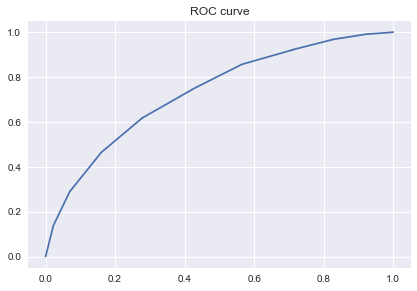

In [590]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots(1, 1)
fig.tight_layout(h_pad=10.0)
ax.plot(lis[0], lis[1])
ax.set_title('ROC curve')

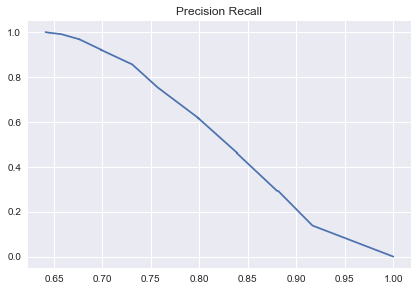

In [591]:
x_rf,y_rf,z_rf=sklearn.metrics.precision_recall_curve(expected, predict_prob)
fig,ax=plt.subplots(1, 1)
fig.tight_layout(h_pad=10.0)
ax.plot(x_rf, y_rf)
ax.set_title('Precision Recall')

Logistic regression

In [601]:
from sklearn.linear_model import LogisticRegression

In [602]:
lr=LogisticRegression(C=0.01)
lr.fit(X_train, Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [603]:
predicted=lr.predict(X_train)
expected=Y_train
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 802 2328]
 [ 495 5057]]


In [604]:
predicted=lr.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[ 361  974]
 [ 224 2163]]


In [595]:
for x,y in zip(X_enc.columns, lr.coef_[0]):
    print(x, y)

age -0.00669585305625
compyear 0.0123515154872
ht_inch -0.161943877967
weight 0.285776345795
ac_assoc_N -0.0070631513829
ac_assoc_Y 0.130895619211
ac_cgdir_N -0.130958890972
ac_cgdir_Y 0.254791358799
ac_evasv_N 0.0475937337103
ac_evasv_Y 0.0762387341175
ac_incid_N 0.0558514831417
ac_incid_Y 0.0679809846859
ac_inves_N 0.0937886262797
ac_inves_Y 0.0300438415483
ac_other_N -0.0269172503335
ac_other_Y 0.150749718161
ac_proxm_N -0.00115050269485
ac_proxm_Y 0.124982970523
ac_rept_N -0.0222349423699
ac_rept_Y 0.146067410198
ac_stsnd_N 0.0123194535788
ac_stsnd_Y 0.111513014249
ac_time_N 0.307502943393
ac_time_Y 0.0801453766073
arstmade_N 0.0857020127711
arstmade_Y -0.173782824905
asltweap_N -0.175735040039
asltweap_Y 0.231618099518
build_H 0.0275078496914
build_M 0.0956718984794
build_T 0.0341866326152
build_U -0.265152012476
build_Z -0.715677793739
city_BRONX 0.839510261567
city_BROOKLYN 0.237593683571
city_MANHATTAN -0.113761215743
city_QUEENS 0.0280389325547
city_STATEN IS 0.0957935352728
c

Race is significant. Being black or latino increases your chances of being frisked, while being white decreases your chances. Sex is also very significant (males are more likely), and people are less likely to be frisked very early in the morning. The Bronx is the worst area, Staten Island is the best. You are more likely to be frisked if you have a heavy build, and less likely if you have a muscular build! Being shorter is better to avoid being frisked

In [605]:
#ROC curve - function can still be improved (get better label)
def graph_roc_funcs(expected, models=[], hybrid=False):
    fig,ax=plt.subplots(1, 1, figsize=(8,6))
    fig.tight_layout(h_pad=10.0)
    ax.set_title('ROC curve')
    
    for mod,i in zip(models, range(len(models))):
        label=str(mod)[0:10]
        pr=mod.predict_proba(X_test)
        predict_prob=[x[1] for x in pr]
        tupl=sklearn.metrics.roc_curve(expected, predict_prob)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label=label)
        
        if hybrid and i==0:
            prs=predict_prob
        else:
            prs=[x+y for x,y in zip(prs,predict_prob)]
    
    if hybrid:
        prs=[x/len(models) for x in prs]
        tupl=sklearn.metrics.roc_curve(expected, prs)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label='hybrid')
    
    ax.legend()

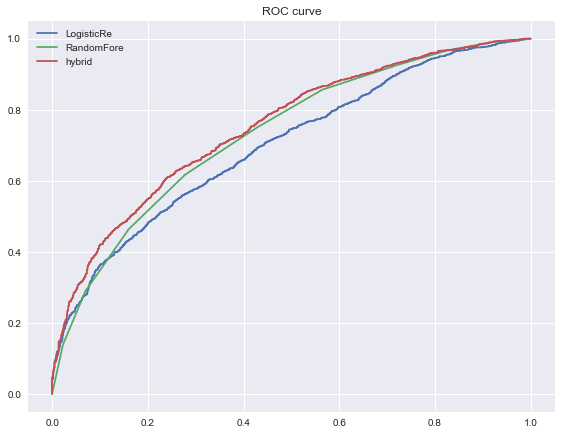

In [606]:
graph_roc_funcs(expected, models=[lr, rf], hybrid=True)

In [607]:
#Precision Recall
def graph_precision_recall(expected, models=[], hybrid=False):
    fig,ax=plt.subplots(1, 1, figsize=(8,6))
    fig.tight_layout(h_pad=10.0)
    ax.set_title('Precision-Recall curve')
    
    for mod,i in zip(models, range(len(models))):
        label=str(mod)[0:10]
        pr=mod.predict_proba(X_test)
        predict_prob=[x[1] for x in pr]
        tupl=sklearn.metrics.precision_recall_curve(expected, predict_prob)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label=label)
    
        if hybrid and i==0:
            prs=predict_prob
        else:
            prs=[x+y for x,y in zip(prs,predict_prob)]
    
    if hybrid:
        prs=[x/len(models) for x in prs]
        tupl=sklearn.metrics.precision_recall_curve(expected, prs)
        lis=[list(x) for x in tupl]
        ax.plot(lis[0], lis[1], label='hybrid')
    
    ax.legend()

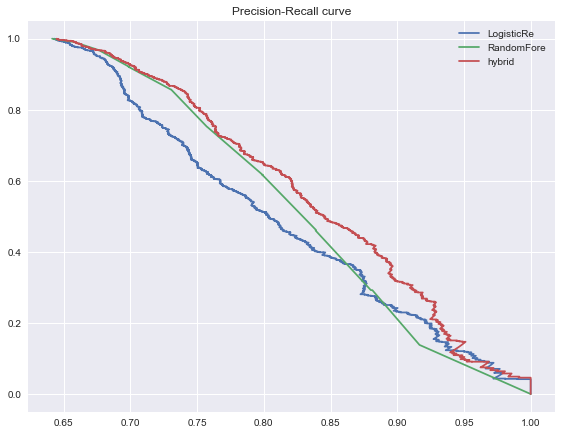

In [608]:
graph_precision_recall(expected, models=[lr, rf], hybrid=True)

Hybrid validation part 2

In [420]:
prob_logit=[x[1] for x in lr.predict_proba(X_test)]
prob_forest=[x[1] for x in rf.predict_proba(X_test)]
hybrid=[(l+f)/2 for l,f in zip(prob_logit,prob_forest)]
hybrid_s=pd.Series(hybrid)

In [421]:
hybrid_s.loc[hybrid_s>=0.5]=1
hybrid_s.loc[hybrid_s<0.5]=0
hybrid_s

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      0.0
21      1.0
22      1.0
23      0.0
24      1.0
25      1.0
26      1.0
27      1.0
28      0.0
29      1.0
       ... 
3692    1.0
3693    1.0
3694    1.0
3695    1.0
3696    1.0
3697    1.0
3698    1.0
3699    1.0
3700    1.0
3701    1.0
3702    1.0
3703    1.0
3704    1.0
3705    1.0
3706    1.0
3707    1.0
3708    1.0
3709    1.0
3710    1.0
3711    1.0
3712    0.0
3713    1.0
3714    1.0
3715    1.0
3716    1.0
3717    1.0
3718    1.0
3719    1.0
3720    0.0
3721    1.0
dtype: float64

In [423]:
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, np.array(hybrid_s)))

[[ 548  806]
 [ 331 2037]]


The hybrid model is a little better than both of them, and seems to do best (I asked my boss why, and apparently it's because of entropy - "all happy families are happy in the same way, but all unhappy families are unhappy in a different way"). This is especially true when you have a variance problem, as we do in this case because of our small sample.

<a id='arrest_made'></a>

<h3> Second model: Arrest made </h3> <br>
This is much harder to predict, for a few reasons. Firstly, the classes are more imbalanced, which means greater variance (it's harder to see what causes what when you don't have a lot of arrests). Secondly, policemen have more information available to them, which once again increases the variance of the model (more things could be causing an arrest - it's harder to pin it down). Lastly, it's unclear if the variables are reported the same way when an arrest occurs. The data may be more accurate, or a little distorted because the police know they will face more scrutiny.

<b> Assumption: if a suspect was frisked or searched, it was before the arrest. </b> <br>
We may have to do a little bit of feature engineering and data work before this model. 

In [500]:
#Using the same function as earlier
X_train, X_test, Y_train, Y_test = build_dataset(df, target='arstmade', feats=after_search)

C:\Users\Baptiste\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Random forest

In [501]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [502]:
import sklearn.metrics
predicted=rf.predict(X_test)
expected=Y_test
print(sklearn.metrics.confusion_matrix(expected, predicted))

[[2788  140]
 [ 300  494]]


In [506]:
for x,y in zip(X_enc.columns, rf.feature_importances_):
    print(x, y)


age 0.037300577897
compyear 0.0
ht_inch 0.0257903655004
weight 0.0339880401939
ac_assoc_N 0.00240631414989
ac_assoc_Y 0.00211623043391
ac_cgdir_N 0.00416853727455
ac_cgdir_Y 0.00353827030933
ac_evasv_N 0.00399045742597
ac_evasv_Y 0.00286468146553
ac_incid_N 0.00425134723748
ac_incid_Y 0.00472725944106
ac_inves_N 0.00427598011651
ac_inves_Y 0.00252901030714
ac_other_N 0.0034526240723
ac_other_Y 0.00467324980007
ac_proxm_N 0.00597812327888
ac_proxm_Y 0.00569632070426
ac_rept_N 0.00688027758761
ac_rept_Y 0.00521022135008
ac_stsnd_N 0.00142212681961
ac_stsnd_Y 0.00107521202219
ac_time_N 0.00315522102728
ac_time_Y 0.00335232737209
arstmade_N 0.0
arstmade_Y 0.0
asltweap_N 0.00501512014734
asltweap_Y 0.00868229631347
build_H 0.00801225792562
build_M 0.000882644143784
build_T 0.00145432432491
build_U 0.00840990539223
build_Z 0.0104962038667
city_BRONX 0.00652063234686
city_BROOKLYN 0.00616736086414
city_MANHATTAN 0.00431001926744
city_QUEENS 0.0149609612527
city_STATEN IS 0.0287993760952
contr

Logistic regression

In [507]:
lr=LogisticRegression()
lr.fit(X_train, Y_train)

C:\Users\Baptiste\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<a id='appendix'></a>

ROC and precision recall curves

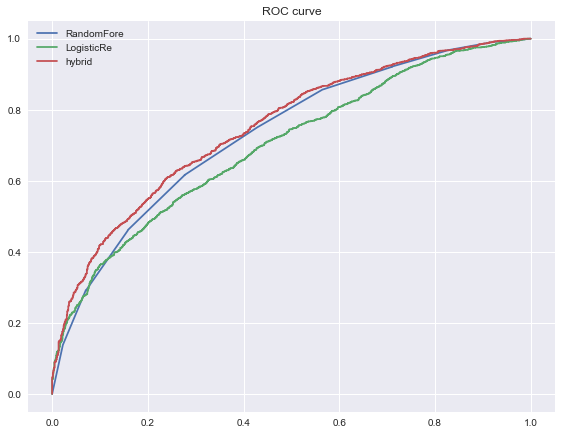

In [609]:
graph_roc_funcs(expected, [rf,lr], hybrid=True)

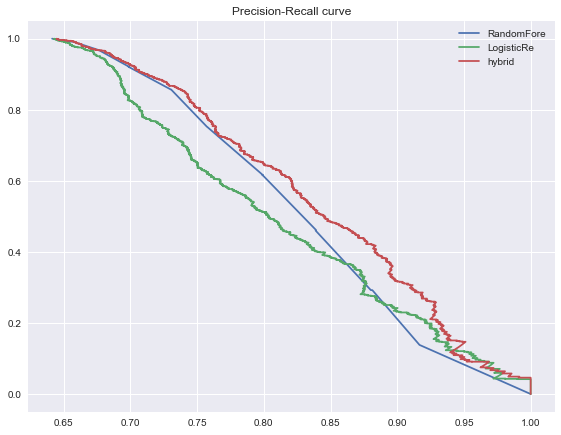

In [611]:
graph_precision_recall(expected, [rf, lr], hybrid=True)

<h3> Appendix </h3> <br>
I stick all my feature selection in here to avoid cluttering the notebook

In [88]:
#batches for histograms
batch_1=[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"addrnum",
"addrpct",
"addrtyp",
"adtlrept",
"age",
"aptnum",
"arstmade",
"arstoffn",
"asltweap",
"beat",
"build"]

batch_2=[
"city",
"comppct",
"compyear",
"contrabn",
"crimsusp",
"crossst",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"datestop",
"detailCM",
"dettypCM",
"dob",
"explnstp",
"eyecolor",
"forceuse",
"frisked",
"haircolr"]

batch_3=[
"ht_feet",
"ht_inch",
"inout",
"knifcuti",
"lineCM",
"machgun",
"officrid",
"offshld",
"offunif",
"offverb",
"othfeatr",
"othpers",
"othrweap",
"pct",
"perobs",
"perstop",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"post",
"premname",
"premtype"]

batch_4=[
"race",
"radio",
"recstat",
"repcmd",
"rescode",
"revcmd",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_verbl",
"riflshot",
"sb_admis",
"sb_hdobj",
"sb_other",
"sb_outln",
"searched",
"sector",
"sex",
"stinter",
"stname",
"sumissue",
"sumoffen",
"timestop",
"trhsloc",
"typeofid",
"weight",
"xcoord",
"ycoord",
"zip",
]

In [379]:
#This is all the infor,ation which a cop could see without searching a suspect
immediately_apparent=[
"ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"age",
"build",
"city",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"ht_inch",
"inout",
"offunif",
"race",
"radio",
"sex",
"timestop",
"trhsloc"]
immediately_apparent_numerics=["age", "ht_inch"]

In [499]:
#This is all the information the policeman will have access to after the search (hypothetically, ofc)
after_search=[
    "ac_assoc",
"ac_cgdir",
"ac_evasv",
"ac_incid",
"ac_inves",
"ac_other",
"ac_proxm",
"ac_rept",
"ac_stsnd",
"ac_time",
"age",
"asltweap",
"build",
"city",
"compyear",
"contrabn",
"cs_bulge",
"cs_casng",
"cs_cloth",
"cs_descr",
"cs_drgtr",
"cs_furtv",
"cs_lkout",
"cs_objcs",
"cs_other",
"cs_vcrim",
"forceuse",
"frisked",
"ht_inch",
"inout",
"knifcuti",
"machgun",
"offunif",
"othpers",
"othrweap",
"pf_baton",
"pf_drwep",
"pf_grnd",
"pf_hands",
"pf_hcuff",
"pf_other",
"pf_pepsp",
"pf_ptwep",
"pf_wall",
"pistol",
"race",
"radio",
"recstat",
"rf_attir",
"rf_bulg",
"rf_furt",
"rf_knowl",
"rf_othsw",
"rf_rfcmp",
"rf_vcact",
"rf_vcrim",
"rf_verbl",
"riflshot",
"sb_admis",
"sb_hdobj",
"sb_other",
"sb_outln",
"searched",
"sex",
"timestop",
"trhsloc",
"weight"]